# Формирование модели монетизации для игры "Космические братья"

## Материалы:

[Презентация](https://disk.yandex.ru/i/yqXc66LQNVaVag)

[Дашборд](https://public.tableau.com/app/profile/lubov.morozova/viz/_16822651293160/Dashboard1?publish=yes)

**Описание проекта:**

Молодое игровое приложение "Космические братья" планирует начать зарабатывать на рекламе. В период с 4 по 10 мая была проведена рекламная кампания и привлечены новые пользователи, нужно проанализировать их поведение и найти закономерности, чтобы сформировать модель монетизации.

Немного об игре: пользователи пытаются преуспеть в колонизации галактики, они строят здания, дерутся с врагами за территории или проводят исследования в виде проектов. Есть два типа игроков:
- PvP - проходят уровень убийством врага
- PvE - проходят уровень завершив исследовательский проект
- также есть пользователи, которые еще не прошли уровень и не выбрали свою тактику

Рекламу планируют показывать на экране выбора постройки, стоимость просмотра одного рекламного баннера(ролика) 0.07 у.е.

**Цель:** \
Изучив поведение пользователей в игре, сформировать модель монетизации для игрового приложения.

**Описание данных:**

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». \
Датасет *game_actions.csv*:
- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Помимо основного датасета есть два датасета с информацией о рекламных активностях. Они также помогут в решении задачи. \
Датасет *ad_costs.csv* содержит колонки:
- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет user_source.csv содержит колонки:
- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

**Декомпозиция задачи:**

1. Прочитать файл, ознакомиться с данными и с общей информацией о датасетах


2. Провести предобработку данных:
    - обработать пропуски
    - обработать дубликаты
    - если нужно, изменить типы данных
    - проверить, что сроки рекламы и даты первых событий пользователей соответствуют указанным заказчиком


3. Провести исследовательский анализ и проверку гипотез: 

    - Определить, какие объекты строят чаще других (все пользователи, с разбивкой на PvP и PvE, по статусу завершения)

    - Определить медианное количество строек на пользователя (общее, с разбивкой на PvP и PvE, по статусу завершения). Можно ли сказать, что совершив N количество строек пользователь точно завершит уровень?

    - Определить количество пользователей, которые прошли уровень завершением проекта, убийством врага или вообще не прошли первый уровень 

    - Оценить время завершения уровня (разница между датой первого события и датой прохождения уровня). Сколько в среднем требуется пользователю, чтобы завершить уровень?

    - Зависит ли время прохождения уровня от тактики игры (PvP, PvE)?
    
    - Есть ли статистическая значимость между количеством строек у разных типов пользователей? (PvP, PvE)

    - Определить расходы на рекламу за весь период (в общем и с разбивкой по каналам)
    
    - Рассчитать CAC для каналов и в общем

    - Какая доля пользователей с каждого канала завершает первый уровень?
    
    - Изучить динамику постройки зданий с течением лайфтайма
    
    - Оценить окупаемость рекламы с различной периодичностью показа, выбрать наиболее эффективный и окупаемый способ

    - Определить периодичность показа рекламы на основании полученный результатов
    
    - Рассчитать предполагаемую прибыль при такой схеме показа

    
4.Сформировать итоговые выводы и рекомендации для отдела маркетинга

## Изучение общей информации о данных

In [1]:
pip install --upgrade matplotlib

     |████████████████████████████████| 11.6 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 76.1 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 86.2 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
# импортируем библиотеки, которые понадобятся
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import warnings
from datetime import datetime, timedelta
from scipy import stats as st

In [3]:
# зададим настройки
sns.set(rc={'figure.figsize':(14,6)})
sns.set_palette('coolwarm')
# исключим красные предупреждения
warnings.filterwarnings('ignore')

In [4]:
# прочитаем все файлы
ad_costs = pd.read_csv('https://code.s3.yandex.net/datasets/ad_costs.csv')
game_actions = pd.read_csv('https://code.s3.yandex.net/datasets/game_actions.csv')
user_source = pd.read_csv('https://code.s3.yandex.net/datasets/user_source.csv')

In [5]:
# ознакомимся с первыми строками датасетов
display(ad_costs.head())
display(game_actions.head())
user_source.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [6]:
# и с общей информацией о типах данных и пропусках
display(ad_costs.info())
display(game_actions.info())
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


**Вывод:** \
Уже на этом этапе видны пропуски, особенно большое количество в столбце `project_type`, и неточности в типах данных - даты имеют тип object. Значит, здесь точно нужна более прицельная предобработка, к которой мы и приступим.

## Предобработка данных

### Работа с пропусками

Мы уже заметили большое количество пропусков, но для наглядности я всегда строю график и смотрю на долю пропусков в столбцах.

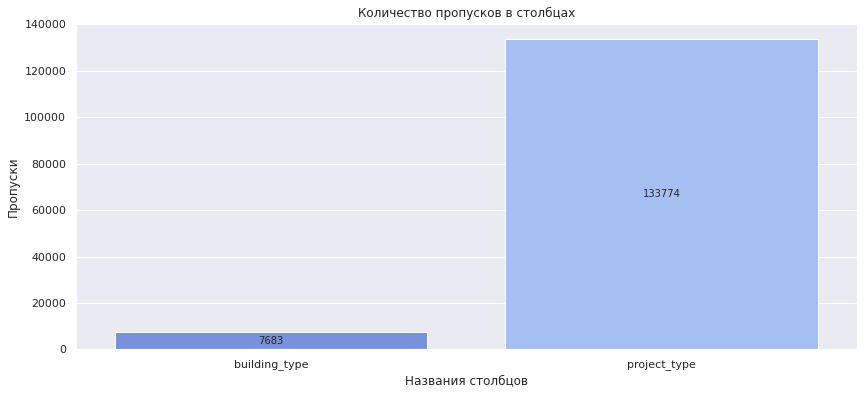

In [7]:
# так как пропуски только в одном из датасетов, будем работать с ним
plt.figure(figsize=(14,6))
miss_data = game_actions.isna().sum(axis=0).reset_index()
miss_data.columns = ['column', 'missing']
miss_data = miss_data[miss_data['missing'] != 0]
miss_data['percent, %'] = (miss_data['missing'] / len(game_actions))*100
ax = sns.barplot(data = miss_data, x = 'column', y = 'missing');
ax.bar_label(ax.containers[0], label_type = 'center')
plt.title('Количество пропусков в столбцах');
plt.ylabel('Пропуски');
plt.xlabel('Названия столбцов');
plt.show();

In [8]:
# доля пропусков в столбцах
miss_data[['column', 'percent, %']]

,column,"percent, %"
2,building_type,5.664258
4,project_type,98.624300


Ого, более 98% пропусков в столбце с проектом. Вряд ли это какая-то ошибка, вероятно, пропуски в тех событиях, которые не связаны с проектом. И более 5% пропусков в столбце с типом строения, это могут быть события как раз с проектом и с завершением уровня.

In [9]:
# посмотрим, есть ли пропуски в типе проекта у события типа проект
game_actions.loc[(game_actions['event'] == 'project') & (game_actions['project_type'].isna())]

,event_datetime,event,building_type,user_id,project_type


Значит, пропуски, действительно, не связаны с ошибкой сбора данных, как и говорил заказчик. Типы проекта не указаны там, где событие не связано с проектом.
Посмотрим теперь на пропуски в типах строений:

In [10]:
game_actions.loc[(game_actions['event'] == 'bulding') & (game_actions['building_type'].isna())]

,event_datetime,event,building_type,user_id,project_type


Отлично, где событие - стройка, там указан тип строения. Ну и в заключении убедимся еще раз, посмотрим на строки, где пропущено и то, и другое значение. Здесь должно быть событие завершения первого уровня.

In [11]:
game_actions.loc[(game_actions['project_type'].isna()) & (game_actions['building_type'].isna())]['event'].unique()

array(['finished_stage_1'], dtype=object)

Отлично, здесь нет никаких неожиданностей: где завершение уровня, там и пропущены типы строений и проектов.

Такие пропуски не требуют замены или удаления, поэтому оставим их как есть.

### Работа с дубликатами

Для начала посмотрим, есть ли явные дубликаты в данных

In [12]:
print(f'Дубликаты в датасете ad_costs: {ad_costs.duplicated().sum()}')
print(f'Дубликаты в датасете game_actions: {game_actions.duplicated().sum()}')
print(f'Дубликаты в датасете user_source: {user_source.duplicated().sum()}')

Дубликаты в датасете ad_costs: 0
Дубликаты в датасете game_actions: 1
Дубликаты в датасете user_source: 0


Ага, есть один дубликат в `game_actions`, удалим его:

In [13]:
game_actions.drop_duplicates(keep='first').reset_index(drop=True)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135635,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135637,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


Можно посмотреть и неявные дубликаты. Вряд ли они будут, так как выгрузка автоматическая, но всё же проверим. Посмотрим уникальные значения там, где могут быть ошибки:

In [14]:
game_actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [15]:
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [16]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [17]:
ad_costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

In [18]:
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Отлично, неявных дубликатов нет. От одного единственного явного мы избавились. Можно перейти к типам данных.

### Работа с типами данных

Даты у нас встречаются в двух датасетах - со стоимостью рекламы и с действиями пользователей. В первом случае - это дата без времени, во втором нам важно не потерять и точное время.

In [19]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [20]:
# посмотрим на результат
display(ad_costs.info())
ad_costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


None

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [21]:
display(game_actions.info())
game_actions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


None

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


Пропуски данных обработаны, дубликаты удалены, типа данных приведены к нужным. На этом предобработку можно завершить.

**Вывод:** \
На данном этапе проведена предобработка данных. Обнаруженные пропуски не связаны с какими-либо ошибками при выгрузке, а вполне логичны и обоснованы (тип проекта пропущен в событиях, не связанных с проектами, а пропуски в типе объекта - в событиях, не связанных с построением объектов). Поэтому принято решение их не удалять и не заменять. \
Найден лишь один дубликат в датасете `game_actions`, он был удален. Неявных дубликатов не выявлено. \
Типы данных у дат приведены к нужным.

## Исследовательский анализ

### Распределение по типам зданий

Отдел маркетинга планирует размещать рекламу на экране с выбором типа постройки. Посмотрим вообще какие типы построек у нас есть и как распределены по частоте встречаемости.

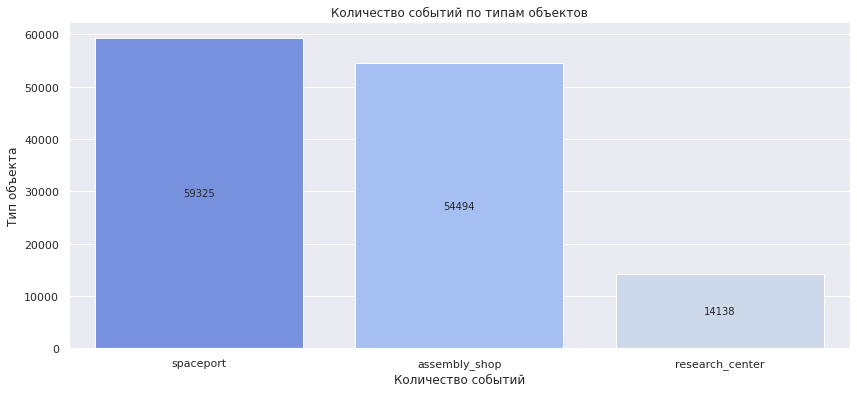

In [22]:
plt.figure(figsize=(14,6));
ax = sns.barplot(
    data = (game_actions.groupby('building_type', as_index=False)
            .agg({'event_datetime':'count'})
            .sort_values(by='event_datetime', ascending=False)
           ),
    x = 'building_type', y ='event_datetime');
ax.bar_label(ax.containers[0], label_type = 'center');
plt.xticks(rotation=0);
plt.title('Количество событий по типам объектов');
plt.xlabel('Количество событий');
plt.ylabel('Тип объекта');
plt.show();

Значит, чаще всего пользователи строят космопорт, а вот исследовательский центр менее популярен. Вероятно, исследовательский центр строят те пользователи, которые будут завершать уровень проектом (PvE игроки), поэтому такое небольшое количество. Посмотрим, верна ли эта теория: как распределены типы объектов в зависимости от типа игрока (PvP, PvE):

In [23]:
# сохраним список игроков, которые завершили первый уровень, и тех, кто не завершил
finished = game_actions.loc[game_actions['event'] == 'finished_stage_1']['user_id'].unique()
not_finish = game_actions.loc[~(game_actions['user_id'].isin(finished))]['user_id'].unique()
# проверим, все ли пользователи попали в списки
len(finished) + len(not_finish)

13576

In [24]:
# теперь сохраним список PvP и PvE игроков
pve = game_actions.loc[game_actions['event'] == 'project']['user_id'].unique()
pvp = game_actions.loc[~(game_actions['user_id'].isin(pve)) & (game_actions['user_id'].isin(finished))]['user_id'].unique()
other = game_actions.loc[~(game_actions['user_id'].isin(pve)) & ~(game_actions['user_id'].isin(pvp))]['user_id'].unique()
# проверии, все ли пользователи распределены
len(pve) + len(pvp) + len(other)

13576

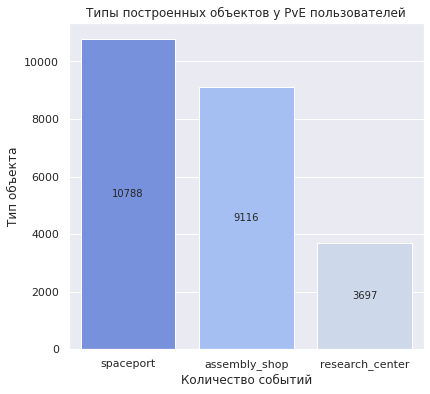

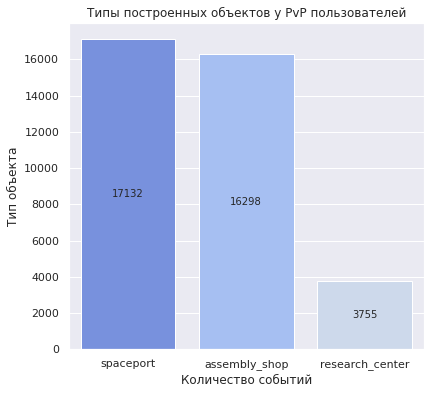

In [25]:
def build_type_visual (row, x, type_p):
    plt.figure(figsize=(14,6));
    ax = sns.barplot(
        data = (game_actions.loc[game_actions['user_id'].isin(row)].groupby('building_type', as_index=False)
                .agg({'event_datetime':'count'})
                .sort_values(by='event_datetime', ascending=False)
               ),
        ax = plt.subplot(1,2,x),
        x = 'building_type', y ='event_datetime');
    ax.bar_label(ax.containers[0], label_type = 'center');
    plt.xticks(rotation=0);
    plt.title(f'Типы построенных объектов у {type_p} пользователей');
    plt.xlabel('Количество событий');
    plt.ylabel('Тип объекта');
    plt.show();

build_type_visual(pve, 1, 'PvE')
build_type_visual(pvp, 2, 'PvP')

Распределение по популярности не отличается у разных типов игроков. Даже у тех, кто делает проект, исследовательские центры не в приоритете. Далее изучим количество строек на игрока, чтобы сделать более подробный вывод.

Теперь у нас есть айди пользователей по виду игры, по статутсу завершения, благодаря этому мы можем комбинировать и смотреть разные группы игроков. Например, тех, кто завершил уровень проектом, тех, кто делал проект, но не завершил уровень и тд.

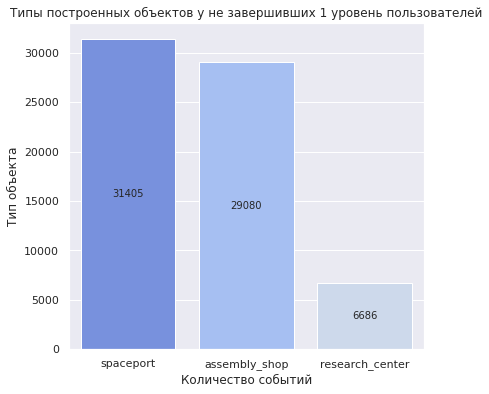

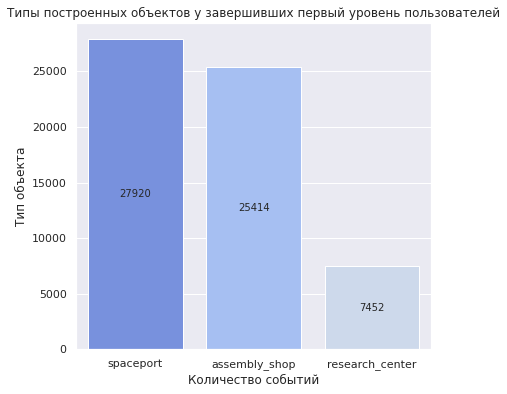

In [26]:
build_type_visual(not_finish, 1, 'не завершивших 1 уровень')
build_type_visual(finished, 2, 'завершивших первый уровень')

Как мы видим, каких-то значимых отличий в типах зданий у завершивших уровень нет. 

**Вывод:** \
Было выявлено, что наибольшей популярностью обладает космопорт, чаще пользователи строят именно его. Хотя сборочный цех имеет лишь небольшое отставание. А вот реже всего игроки выбирают для постройки исследовательский центр. При этом каких-то отличий в выборе объекта у PvE и PvP игроков выявлено не было.

### Сколько строек приходится на пользователя?

Чтобы примерно понимать, сколько раз пользователь может увидеть рекламный баннер, нужно посмотреть, сколько вообще строк приходится на пользователя (считаем, что каждая стройка сопровождается выбором объекта - соответственно, просмотром рекламы).

In [27]:
# сначала выведем количество людей в наших сегментах
print(f'Количество PvE игроков {len(pve)}, количество PvP игроков {len(pvp)}')
print(f'Количество завершивших уровень {len(finished)}, а не завершивших {len(not_finish)}')
pve_fin = game_actions.loc[(game_actions['user_id'].isin(pve)) \
                               & game_actions['user_id'].isin(finished)]['user_id'].unique()
pvp_fin = game_actions.loc[(game_actions['user_id'].isin(pvp)) \
                               & game_actions['user_id'].isin(finished)]['user_id'].unique()
print(f'Количество завершивших проектом - PvE {len(pve_fin)}')
print(f'Количество завершивших убийством врага - PvP {len(pvp_fin)}')

Количество PvE игроков 1866, количество PvP игроков 3951
Количество завершивших уровень 5817, а не завершивших 7759
Количество завершивших проектом - PvE 1866
Количество завершивших убийством врага - PvP 3951


Да, вполне логично, что те, кого мы отнесли к определенной категории - завершили уровень. Пользователи, которые распределены в список `other` пока не завершили уровень, поэтому мы не можем узнать их тип игры, ведь отдельно события "убийство врага" у нас нет.

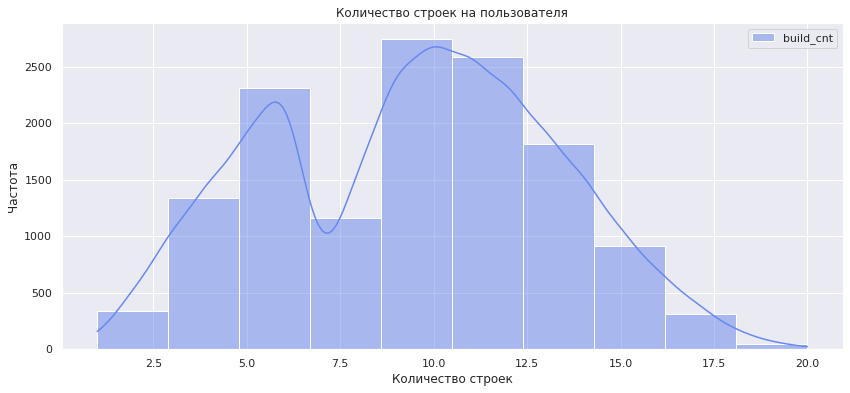

In [28]:
# найдем сколько строит каждый пользователь
def build_user(data):
    plt.figure(figsize=(14,6));
    build_user = (data
                  .groupby('user_id', as_index=False)
                  .agg({'event_datetime':'count'})
                  .rename(columns={'event_datetime':'build_cnt'})
                  .sort_values(by = 'build_cnt', ascending=False)
                 )
    return build_user
build_all = build_user(game_actions.loc[game_actions['event'] == 'building'])
sns.histplot(build_all, bins=10, kde=True);
plt.title('Количество строек на пользователя');
plt.xlabel('Количество строек');
plt.ylabel('Частота');
plt.show();

На каждого пользователя приходится от 1 до 20 строек. Интересный провал наблюдается между 7 и 8 стройками. \
Найдем медианное число строек и перцентили.

In [29]:
print(f'Медианное количество строек во всём датасете {build_all["build_cnt"].median()}')
print(f'95 перцентиль = {np.percentile(build_all["build_cnt"], [95][0])}, \
99 = {np.percentile(build_all["build_cnt"], [99][0])}')

Медианное количество строек во всём датасете 10.0
95 перцентиль = 16.0, 99 = 18.0


Получается, большинство пользователей имеет по 10 построенных зданий. Значит, среднестатистический пользователь будет видеть рекламу 10 раз. Посмотрим теперь, изменится ли это число в зависимости от типа игрока.

<Figure size 1008x432 with 0 Axes>

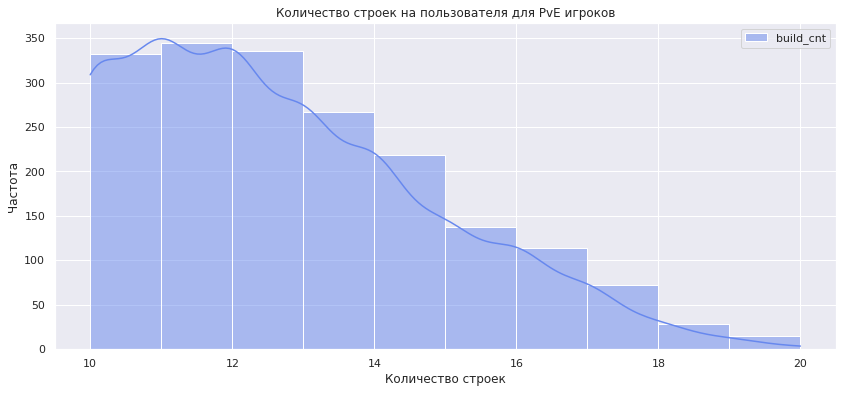

In [30]:
build_pve = build_user(game_actions.loc[(game_actions['event'] == 'building') & (game_actions['user_id'].isin(pve))])
plt.figure(figsize=(14,6));
sns.histplot(build_pve, bins=10, kde=True);
plt.title('Количество строек на пользователя для PvE игроков');
plt.xlabel('Количество строек');
plt.ylabel('Частота');
plt.show();

In [31]:
print(f'Медианное количество строек среди PvE пользователей {build_pve["build_cnt"].median()}')
print(f'95 перцентиль = {np.percentile(build_pve["build_cnt"], [95][0])}, \
99 = {np.percentile(build_pve["build_cnt"], [99][0])}')

Медианное количество строек среди PvE пользователей 12.0
95 перцентиль = 17.0, 99 = 18.0


Количество зданий на PvE игроков варьируется от 10 до 20. При этом медианное количество выше, чем во всем датасете. \
Посмотрим, насколько активно строят объекты PvP игроки:

<Figure size 1008x432 with 0 Axes>

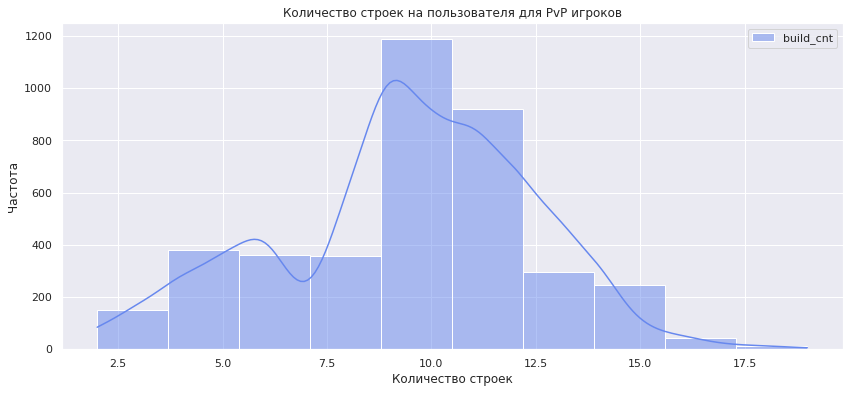

In [32]:
build_pvp = build_user(game_actions.loc[(game_actions['event'] == 'building') & (game_actions['user_id'].isin(pvp))])
plt.figure(figsize=(14,6));
sns.histplot(build_pvp, bins=10, kde=True);
plt.title('Количество строек на пользователя для PvP игроков');
plt.xlabel('Количество строек');
plt.ylabel('Частота');
plt.show();

In [33]:
print(f'Медианное количество строек среди PvE пользователей {build_pvp["build_cnt"].median()}')
print(f'95 перцентиль = {np.percentile(build_pvp["build_cnt"], [95][0])}, \
99 = {np.percentile(build_pvp["build_cnt"], [99][0])}')

Медианное количество строек среди PvE пользователей 10.0
95 перцентиль = 14.0, 99 = 16.0


Больше 1000 PvP игроков строят менее 10 объектов, да и медианное количество строек на игрока меньше, чем у PvE игроков. Можем ли мы сказать, что PvE пользователи строят больше объектов? Проверим статистическую значимость. \
H0 - пользователи PvE и PvP строят одинаковое количество объектов \
H1 - пользвоатели строят разное количество объектов \
Уровень значимость 0.05

Но перед этим проверим, нормально ли распределены выборки с помощью теста Шапиро-Уилка. Если p-value будет меньше 0.05 - выборки не нормальны.

In [34]:
if st.shapiro(build_pve['build_cnt']).pvalue < 0.05:
    print('Распределение отличается от нормального')
else:
    print('Распределение нормальное')

Распределение отличается от нормального


In [35]:
if st.shapiro(build_pvp['build_cnt']).pvalue < 0.05:
    print('Распределение отличается от нормального')
else:
    print('Распределение нормальное')

Распределение отличается от нормального


Выборки распределены не нормально. Будем использовать критерий Манна-Уитни. Есть много споров в разных источниках об использовании данного критерия. Конечно, лучшим вариантом, наверное, был бы бутстрап-метод, но я пока недостаточно освоила его.

In [36]:
alpha = 0.05 #критическое значение p-value
result = st.mannwhitneyu(
    build_pve['build_cnt'],
    build_pvp['build_cnt'],
    ) 

print('Значение p-value:', result.pvalue)

#проверяем гипотезу: H0 - пользователи, которые завершили строят столько же зданий, сколько и не завершившие
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value: 5.211926275022306e-305
Отвергаем нулевую гипотезу


Ага, значит PvE пользователи строят достоверно больше объектов.

Теперь посмотрим, сколько строек совершают пользователи, завершившие первый уровень, и не завершившие. Здесь тоже должны быть отличия.

In [37]:
build_finish = build_user(game_actions.loc[(game_actions['event'] == 'building') & (game_actions['user_id'].isin(finished))])
build_finish['build_cnt'].median()

11.0

<Figure size 1008x432 with 0 Axes>

In [38]:
build_not_finish = build_user(game_actions.loc[(game_actions['event'] == 'building') & (game_actions['user_id'].isin(not_finish))])
build_not_finish['build_cnt'].median()

8.0

<Figure size 1008x432 with 0 Axes>

Да, медианное количество зданий у тех, кто не завершил уровень ниже. Но посмотрим, значимо ли это отличие. \
H0 - среднее количество строек на пользователя среди завершивших и не завершивших уровень одинаково \
H1 - среднее количество строек на пользователей разнится в зависимости от статуса завершения уровня
Уровень значимости 0.05

Но перед этим проверим, нормально ли распределены выборки с помощью теста Шапиро-Уилка. Если p-value будет меньше 0.05 - выборки не нормальны.

In [39]:
if st.shapiro(build_finish['build_cnt']).pvalue < 0.05:
    print('Распределение отличается от нормального')
else:
    print('Распределение нормальное')

Распределение отличается от нормального


In [40]:
if st.shapiro(build_not_finish['build_cnt']).pvalue < 0.05:
    print('Распределение отличается от нормального')
else:
    print('Распределение нормальное')

Распределение отличается от нормального


Выборки распределены не нормально. Снова используем критерий Манна-Уитни. 

In [41]:
alpha = 0.05 #критическое значение p-value
result = st.mannwhitneyu(
    build_finish['build_cnt'],
    build_not_finish['build_cnt'],
    ) 

print('Значение p-value:', result.pvalue)

#проверяем гипотезу: H0 - пользователи, которые завершили строят столько же зданий, сколько и не завершившие
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')        

Значение p-value: 1.6927051876296536e-161
Отвергаем нулевую гипотезу


Да, действительно, статистически значимо незавершившие уровень строят меньше зданий, что и следовало ожидать.

**Вывод:** \
В среднем пользователи совершают от 1 до 20 построек. Медианное количество строек на человека - 10. При этом PvE игроки строят достоверно больше объектов, чем PvP, медианное количество  - 12 строек. \
Среди тех, кто не завершил уровень, медианное количество строек на человека равно 8. При этом они достоверно меньше объектов строят, чем те, кто завершил уровень. \
Понимание того, сколько вообще построек делают игроки поможет нам лучше сформировать план показа рекламы в дальнейшем.

### Изучение времени прохождения первого уровня

Посмотрим, какая доля пользователей завершила первый уровень за этот месяц.

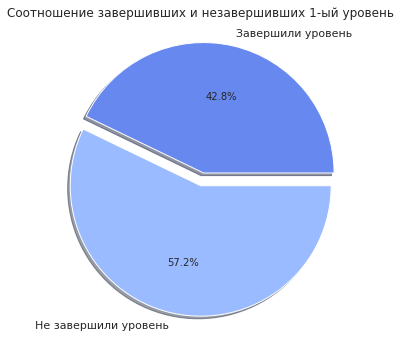

In [42]:
x = ['Завершили уровень', 'Не завершили уровень']
y = [len(finished), len(not_finish)]
plt.figure(figsize=(14,6));
plt.pie(y, labels=x, 
        autopct='%1.1f%%',
        shadow=True,
        explode=(0.1,0));
plt.title('Соотношение завершивших и незавершивших 1-ый уровень');
plt.show();

Довольно большой процент пользователей завершил уровень. Однако более половины всё еще проходят 1-ый уровень или вовсе забросили игру.

Изучим время прохождения уровня у разных сегментов пользователей.

In [43]:
# найдем время первого события у каждого пользователя
first_events = (game_actions.sort_values(by=['user_id', 'event_datetime'])
                .groupby('user_id', as_index=False)
                .agg({'event_datetime':'first',
                     'event':'first',
                     'building_type':'first',
                     'project_type':'first'
                     })
                .rename(columns={'event_datetime':'first_dt', 'event':'first_event'})
               )
first_events

,user_id,first_dt,first_event,building_type,project_type
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06 01:07:37,building,assembly_shop,None
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06 03:09:12,building,assembly_shop,None
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05 18:08:52,building,assembly_shop,None
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,assembly_shop,None
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05 13:49:58,building,assembly_shop,None
...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,building,assembly_shop,None
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,2020-05-04 11:58:14,building,assembly_shop,None
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04 02:05:09,building,assembly_shop,None
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,2020-05-04 20:28:28,building,assembly_shop,None


In [44]:
# и теперь получим время последнего события
last_events = (game_actions.sort_values(by=['user_id', 'event_datetime'])
                .groupby('user_id', as_index=False)
                .agg({'event_datetime':'last',
                     'event':'last',
                     'building_type':'last',
                     'project_type':'last'
                     })
                .rename(columns={'event_datetime':'last_dt', 'event':'last_event'})
               )
# объединим таблицы с первым и последним событием
events_user = first_events.merge(last_events[['user_id', 'last_dt', 'last_event']])
# отфильтуруем тех, кто закончил первый уровень
events_user.loc[events_user['last_event'] == 'finished_stage_1']

,user_id,first_dt,first_event,building_type,project_type,last_dt,last_event
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,assembly_shop,None,2020-05-12 07:40:47,finished_stage_1
6,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,building,assembly_shop,None,2020-05-17 21:47:49,finished_stage_1
7,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,building,assembly_shop,None,2020-05-16 19:57:40,finished_stage_1
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,building,assembly_shop,None,2020-05-15 16:02:01,finished_stage_1
10,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,building,assembly_shop,None,2020-05-16 13:48:39,finished_stage_1
...,...,...,...,...,...,...,...
13568,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,2020-05-06 06:34:18,building,assembly_shop,None,2020-05-19 04:03:24,finished_stage_1
13570,ffe810f4-1a1f-464b-924d-6f120b0cb8df,2020-05-04 17:46:05,building,assembly_shop,None,2020-05-18 02:03:36,finished_stage_1
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,building,assembly_shop,None,2020-05-11 22:15:54,finished_stage_1
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04 02:05:09,building,assembly_shop,None,2020-05-12 13:01:52,finished_stage_1


In [45]:
# теперь найдем разницу между первым и последним событием в днях
events_user['diff_dt'] = (events_user['last_dt'] - events_user['first_dt']).dt.days
events_user.loc[events_user['last_event'] == 'finished_stage_1']

,user_id,first_dt,first_event,building_type,project_type,last_dt,last_event,diff_dt
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,building,assembly_shop,None,2020-05-12 07:40:47,finished_stage_1,6
6,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,building,assembly_shop,None,2020-05-17 21:47:49,finished_stage_1,12
7,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,building,assembly_shop,None,2020-05-16 19:57:40,finished_stage_1,12
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,building,assembly_shop,None,2020-05-15 16:02:01,finished_stage_1,11
10,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,building,assembly_shop,None,2020-05-16 13:48:39,finished_stage_1,6
...,...,...,...,...,...,...,...,...
13568,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,2020-05-06 06:34:18,building,assembly_shop,None,2020-05-19 04:03:24,finished_stage_1,12
13570,ffe810f4-1a1f-464b-924d-6f120b0cb8df,2020-05-04 17:46:05,building,assembly_shop,None,2020-05-18 02:03:36,finished_stage_1,13
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,building,assembly_shop,None,2020-05-11 22:15:54,finished_stage_1,7
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,2020-05-04 02:05:09,building,assembly_shop,None,2020-05-12 13:01:52,finished_stage_1,8


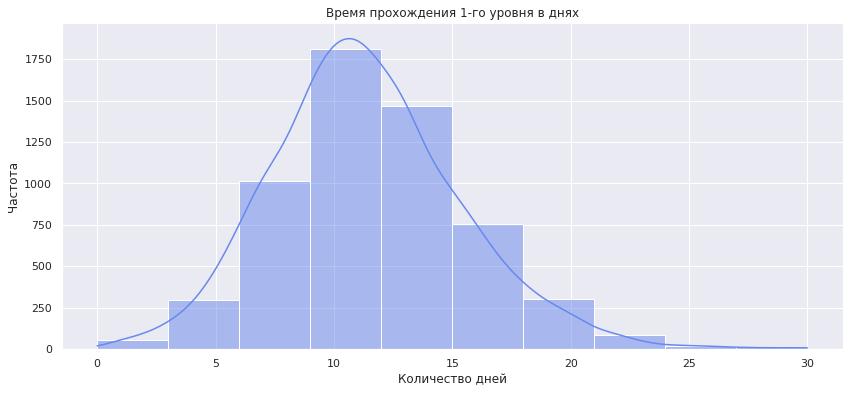

In [46]:
# посмотрим распределение времени прохождения уровня
plt.figure(figsize=(14,6));
sns.histplot(events_user.loc[events_user['last_event'] == 'finished_stage_1']['diff_dt'], bins=10, kde=True);
plt.title('Время прохождения 1-го уровня в днях');
plt.xlabel('Количество дней');
plt.ylabel('Частота');
plt.show();

In [47]:
# найдем медианное время прохождения
events_user.loc[events_user['last_event'] == 'finished_stage_1']['diff_dt'].median()

11.0

Большая часть пользователей проходит первый уровень за 1.5 - 2 недели. Медианное количество дней на завершение уровня - 11. При этом странно, что есть пользователи, которые завершили уровень за 0 дней. Может быть, они, конечно, играли в течение всего дня. Мы не можем посмотреть время сессий, но можем посмотреть количество их построек.

In [48]:
# сначала посмотрим, что это за пользователи
events_user.loc[(events_user['diff_dt'] == 0) & (events_user['last_event'] == 'finished_stage_1')]

,user_id,first_dt,first_event,building_type,project_type,last_dt,last_event,diff_dt
207,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,2020-05-07 16:40:32,building,assembly_shop,None,2020-05-08 02:19:33,finished_stage_1,0
1894,2204ae7f-892b-494d-bd58-28816ff35eb5,2020-05-07 02:25:27,building,assembly_shop,None,2020-05-08 01:02:51,finished_stage_1,0
10614,c8180f71-68dc-4fd5-ba6e-ba5f5d0d28f7,2020-05-08 16:08:29,building,assembly_shop,None,2020-05-09 11:52:33,finished_stage_1,0
10932,ced7b368-818f-48f6-9461-2346de0892c5,2020-05-04 00:13:21,building,assembly_shop,None,2020-05-04 19:47:29,finished_stage_1,0


Ага, для вычисления дней используется 24-часовой способ,а  не календарный. Посмотрим, сколько построек успели сделать эти пользователи за день.

In [49]:
game_actions.loc[game_actions['user_id'].isin(events_user.loc[(events_user['diff_dt'] == 0) \
                                                              & (events_user['last_event'] == 'finished_stage_1')]['user_id'])]

,event_datetime,event,building_type,user_id,project_type
73,2020-05-04 00:13:21,building,assembly_shop,ced7b368-818f-48f6-9461-2346de0892c5,NaN
4222,2020-05-04 12:51:34,building,spaceport,ced7b368-818f-48f6-9461-2346de0892c5,NaN
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN
28186,2020-05-07 02:25:27,building,assembly_shop,2204ae7f-892b-494d-bd58-28816ff35eb5,NaN
33803,2020-05-07 14:44:04,building,spaceport,2204ae7f-892b-494d-bd58-28816ff35eb5,NaN
34652,2020-05-07 16:40:32,building,assembly_shop,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,NaN
34732,2020-05-07 16:53:35,building,assembly_shop,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,NaN
35889,2020-05-07 19:28:57,building,spaceport,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,NaN
38510,2020-05-08 01:02:51,finished_stage_1,NaN,2204ae7f-892b-494d-bd58-28816ff35eb5,NaN
39142,2020-05-08 02:19:33,finished_stage_1,NaN,03990bc0-47b6-44ce-9f8b-3afb1a97d0e7,NaN


Никто из них не реализовал проект, значит, так быстро завершали уровень только PvP игроки. И, действительно, за день они успевали сделать несколько зданий. Но мы убедились, что здесь нет какой-либо ошибки выгрузки.

Теперь нам нужно проверить, влияет ли вид игрока на время прохождения первого уровня.

In [50]:
# для начала сохраним списки дней 
days_pve = events_user.loc[events_user['user_id'].isin(pve)]['diff_dt']

days_pvp = events_user.loc[events_user['user_id'].isin(pvp)]['diff_dt']

Посмотрим на медианное время прохождения уровня в двух группах математически.

In [51]:
print(f'Медианное время прохождения уровня PvE пользователями {days_pve.median()} дней')
print(f'Медианное время прохождения уровня PvP пользователями {days_pvp.median()} дней')

Медианное время прохождения уровня PvE пользователями 13.0 дней
Медианное время прохождения уровня PvP пользователями 10.0 дней


Как мы видим, пользователи, реализующие проект, тратят больше времени на завершение уровня. Есть ли статистически значимые отличия? \
H0 - время прохождения 1-го уровня одинаково у PvE и PvP пользователей. \
H1 - время различное. \
Уровень значимости 0.05

Сначала проверим данные на нормальность распределения с помощью теста Шапиро-Уилка. Если pvalue будет меньше 0.05 - данные распределены не нормально.

In [52]:
if st.shapiro(days_pve).pvalue < 0.05:
    print('Распределение отличается от нормального')
else:
    print('Распределение нормальное')

Распределение отличается от нормального


In [53]:
if st.shapiro(days_pvp).pvalue < 0.05:
    print('Распределение отличается от нормального')
else:
    print('Распределение нормальное')

Распределение отличается от нормального


Значит, здесь снова мы будем использовать критерий Манна-Уитни.

In [54]:
alpha = 0.05 #критическое значение p-value
result = st.mannwhitneyu(
    days_pve,
    days_pvp,
    ) 

print('Значение p-value:', result.pvalue)

#проверяем гипотезу: H0 - время прохождения 1-го уровня одинаково у PvE и PvP пользователей
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')     


Значение p-value: 1.4810402498079134e-105
Отвергаем нулевую гипотезу


Итак, мы получили, что пользователи, которые реализуют проект, значимо дольше проходят 1-ый уровень, чем пользователи, убивающие врага.

Также хочется посмотреть, какое медианное время игры у тех, кто так и не завершил первый уровень. И продолжают ли они играть в игру или забросили. Чтобы понять, с какого дня показывать рекламу.

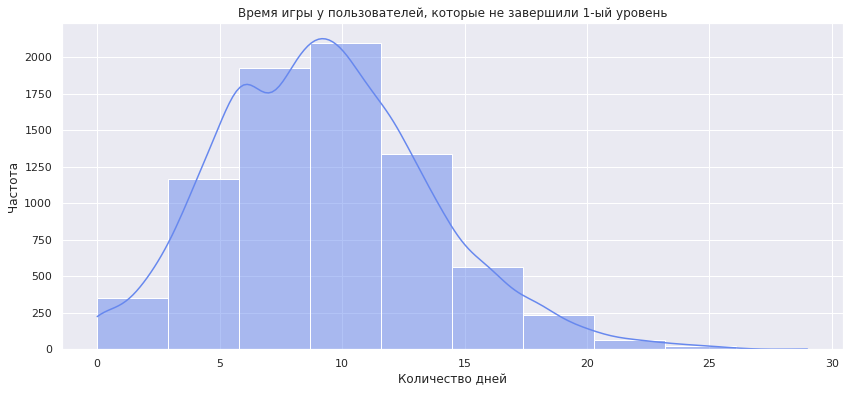

In [55]:
plt.figure(figsize=(14,6));
sns.histplot(events_user.loc[events_user['last_event'] != 'finished_stage_1']['diff_dt'], bins=10, kde=True);
plt.title('Время игры у пользователей, которые не завершили 1-ый уровень');
plt.xlabel('Количество дней');
plt.ylabel('Частота');
plt.show();

In [56]:
events_user.loc[events_user['last_event'] != 'finished_stage_1']['diff_dt'].median()

9.0

In [57]:
events_user.loc[events_user['last_event'] != 'finished_stage_1']['diff_dt'].max()

29

**Вывод:** \
Из 13 тысяч игроков первый уровень прошли 42.8%. Большая часть пользователей завершает уровень за 1.5-2 недели. Медианное время прохождения - 11 дней. При этом есть игроки, которые проходят 1-ый уровень в первый же день, есть любителя растянуть удовольствие на весь месяц. \
Было выявлено, что PvE пользователи значимо дольше проходят первый уровень, чем PvP игроки. \
При этом даже незавершившие уровень "живут" в игре в среднем 9 дней. \
Всё это помогает нам в принятии решения о расположении рекламы. Привязывать начало показа лучше к количеству строек, а не к дню игры. Так как есть пользователи, завершающие уровень раньше, а есть те, кто дольше играет.

### Формирование модели монетизации рекламы

Итак, нам известно, что один показ рекламы пользователю приносит 0.07 у.е.. При этом рекламный баннер будет отображаться на экране выбора постройки. И наша задача выбрать оптимальное время показа, чтобы не вызвать недовольство новых игроков, но и при этом окупить вложения в рекламу.

В среднем пользователи завершают уровень за 1.5 - 2 недели (медиана 11 дней). За жизнь в игре игроки строят от 1 до 20 зданий. Медианное количество построек - 10 зданий на человека. При этом PvE игроки строят больше объектов, чем PvP. И завершившие игру строят больше зданий, чем те, кто не завершил.

Исходя из этого нужно выбрать оптимальную схему показа рекламы.

In [58]:
# еще раз ознакомимся с датасетом трат на рекламу
ad_costs.head(10)

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [59]:
# сколько потратили на рекламу за выбранный период?
print('Траты на рекламу за весь период по всем каналам', round(ad_costs['cost'].sum(),2))

Траты на рекламу за весь период по всем каналам 7603.58


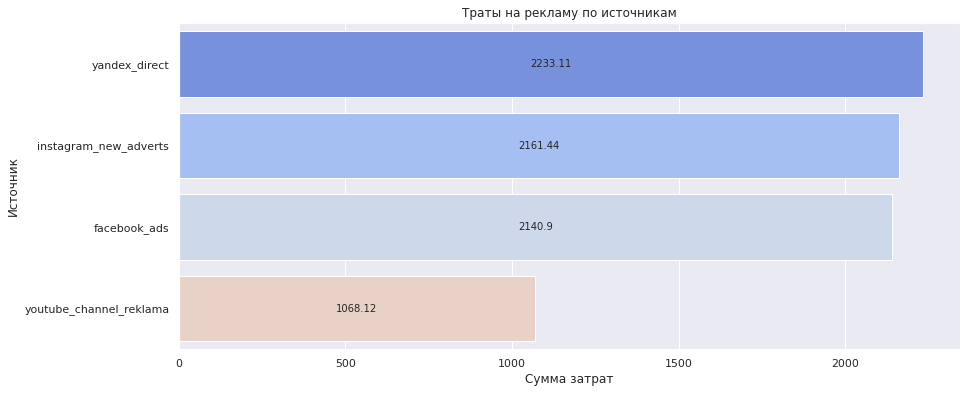

In [60]:
plt.figure(figsize=(14,6));
ax = sns.barplot(data = ad_costs.groupby('source', as_index=False).agg({'cost':'sum'}).sort_values(by='cost', ascending=False),
                 x = 'cost', y = 'source');
ax.bar_label(ax.containers[0], label_type = 'center');
plt.title('Траты на рекламу по источникам');
plt.xlabel('Сумма затрат');
plt.ylabel('Источник');
plt.show();

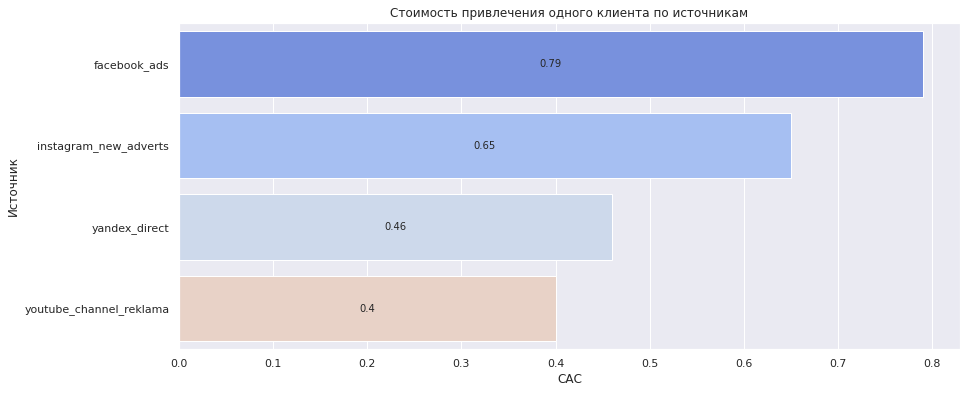

In [61]:
cac = (user_source.groupby('source', as_index=False).agg({'user_id':'count'}).merge(
    ad_costs.groupby('source', as_index=False).agg({'cost':'sum'}), on = 'source')
      )
cac['cac'] = round(cac['cost'] / cac['user_id'],2)
plt.figure(figsize=(14,6));
ax = sns.barplot(data = cac, x = 'cac', y = 'source');
ax.bar_label(ax.containers[0], label_type = 'center');
plt.title('Стоимость привлечения одного клиента по источникам');
plt.xlabel('САС');
plt.ylabel('Источник');
plt.show();

Больше всего денег было потрачено на рекламу в Яндекс Директе. Но при этом дороже привлечение одного пользователя обойдется на Фейсбуке. \
Причем, если вспомнить, что показ одного объявления приносит 0.07 у.е, а каждый пользователь в среднем строит (=смотрит объявление) 10 зданий, значит, реклама из всех источников, кроме Фейсбука, в теории должна окупаться. \
А реклама фейсбука окупается только у PvE пользователей, которые в среднем строят 12 зданий. Тогда нужно подумать о том, чтобы мотивировать игроков, привлеченных с Фейсбука, выбрать именно PvE тактику игры. Может быть, какие-то бонусы или промокоды на исследования, идеи для проектов и т.д включить в рекламный баннер.

Посмотрим, есть ли какие-то отличия в завершении уровня среди пользователей из разных источников.

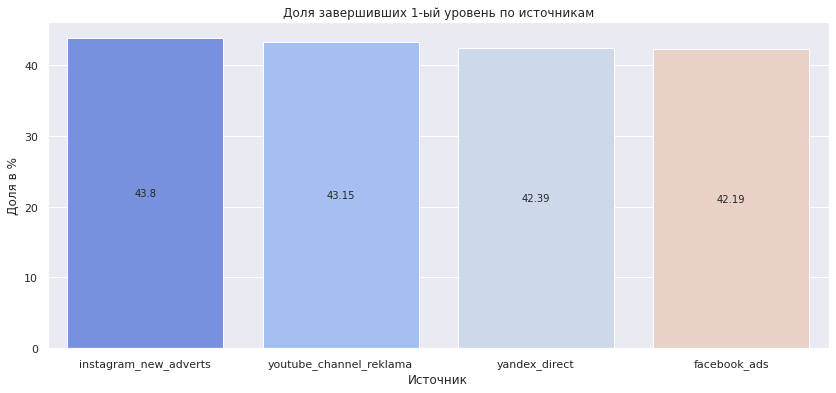

In [62]:
finished_source = (user_source.loc[user_source['user_id'].isin(finished)]
                   .groupby('source', as_index=False)
                   .agg({'user_id':'count'})
                   .rename(columns={'user_id':'finished'})
                  )
finished_source = finished_source.merge(user_source.groupby('source', as_index=False).agg({'user_id':'count'}, on = 
                                                                       'source').rename(columns={'user_id':'all'})
                     ) 
finished_source['share_finished'] = round(finished_source['finished']*100 / finished_source['all'],2)
plt.figure(figsize=(14,6));
ax = sns.barplot(data = finished_source.sort_values(by='share_finished', ascending=False), 
                 y = 'share_finished', x = 'source');
ax.bar_label(ax.containers[0], label_type = 'center');
plt.title('Доля завершивших 1-ый уровень по источникам');
plt.ylabel('Доля в %');
plt.xlabel('Источник');
plt.show();

Большой разницы в проценте завершения уровня у источников нет. Лидером является инстаграмм, однако разрыв между первым и последним местом лишь чуть больше 1%.

In [63]:
print(f'Значит, на рекламу было потрачено {round(ad_costs["cost"].sum(),2)} у.е.')
print(f'За весь период с 4.05 по 10.05 реклама привлекла {len(user_source)} пользователей')
print(f'Они построили в сумме {len(game_actions.loc[game_actions["event"] == "building"])} зданий')
print(f'Если один показ рекламы стоит 0.07 у.е, значит, теоретически, показывая рекламу сразу и всем, приложение заработало бы \
{round(len(game_actions.loc[game_actions["event"] == "building"])*0.07,2)} у.е')

Значит, на рекламу было потрачено 7603.58 у.е.
За весь период с 4.05 по 10.05 реклама привлекла 13576 пользователей
Они построили в сумме 127957 зданий
Если один показ рекламы стоит 0.07 у.е, значит, теоретически, показывая рекламу сразу и всем, приложение заработало бы 8956.99 у.е


Но показывать рекламу всем и сразу мы не можем, так как это вызовет негативные последствия. \
Посмотрим, как меняется активность игроков (относительно построек) с течением времени.

In [64]:
# сделаем столбец с лайфтаймом и порядковым номером события
life = first_events.merge(
        game_actions[['user_id', 'event_datetime', 'event']], on='user_id', how='left'
    )
# переведем даты в дни
life['first_dt'] = life['first_dt'].dt.date
life['event_datetime'] = life['event_datetime'].dt.date

life['lifetime'] = (
       life['event_datetime'] - life['first_dt']
    ).dt.days

life

,user_id,first_dt,first_event,building_type,project_type,event_datetime,event,lifetime
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-06,building,0
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-06,building,0
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-06,building,0
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-09,building,3
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-09,building,3
...,...,...,...,...,...,...,...,...
135635,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-23,building,15
135636,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-24,building,16
135637,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-25,project,17
135638,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-25,building,17


In [65]:
# сделаем столбец с типом игрока
def type_player(users):
    if users in pve:
        return 'PvE'
    if users in pvp:
        return 'PvP'
    else:
        return 'other'

life['type_player'] = life['user_id'].apply(type_player)

In [66]:
# добавим столбец с источником привлечения пользователя
life = life.merge(user_source, on = 'user_id', how='left')
life

,user_id,first_dt,first_event,building_type,project_type,event_datetime,event,lifetime,type_player,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-06,building,0,other,facebook_ads
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-06,building,0,other,facebook_ads
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-06,building,0,other,facebook_ads
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-09,building,3,other,facebook_ads
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,building,assembly_shop,None,2020-05-09,building,3,other,facebook_ads
...,...,...,...,...,...,...,...,...,...,...
135635,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-23,building,15,PvE,facebook_ads
135636,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-24,building,16,PvE,facebook_ads
135637,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-25,project,17,PvE,facebook_ads
135638,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,2020-05-08,building,assembly_shop,satellite_orbital_assembly,2020-05-25,building,17,PvE,facebook_ads


Посмотрим, как меняется количество построек в течение лайфтайма по типам пользователей:

<Figure size 1008x432 with 0 Axes>

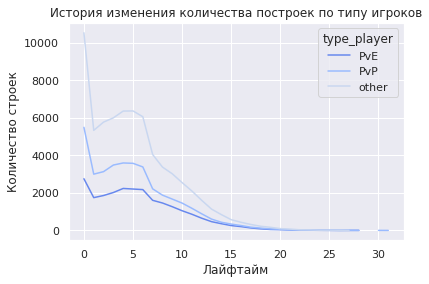

In [67]:
# построим график
plt.figure(figsize=(14,6));
life.loc[life['event'] == 'building']\
.pivot_table(index = 'lifetime', columns = 'type_player', values = 'event', aggfunc = 'count').plot();
plt.title('История изменения количества построек по типу игроков');
plt.xlabel('Лайфтайм');
plt.ylabel('Количество строек');
plt.show();

По этому графику видно, что нужно успевать начать показ рекламы до 5 дня лайфтайма. При этом PvE пользователи, как мы видим, вносят меньший вклад в общее количество построенных объектов, так как это немногочисленная группа (лишь 1866 человек), но мы помним, что каждый из них активнее строит здания, чем PvP игроки. 

Посмотрим, какую долю составляют PvE игроки среди тех, кто был привлечен с Фейсбука, так как там самая высокая цена за привлечение пользователя, которая лучше окупается игроками PvE.

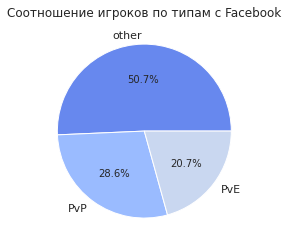

In [68]:
life.loc[life['source'] == 'facebook_ads']['type_player'].value_counts().plot(kind = 'pie',
                                                                              autopct='%1.1f%%',
                                                                              ylabel = '');
plt.title('Соотношение игроков по типам с Facebook');

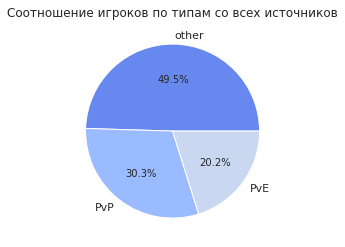

In [69]:
life['type_player'].value_counts().plot(kind = 'pie',
                                        autopct='%1.1f%%',
                                        ylabel = '');
plt.title('Соотношение игроков по типам со всех источников');

Хм, их меньше, чем PvP игроков, но более половины пользователей еще не завершили уровень, поэтому не могут быть отнесены к какому-либо типу, есть шанс "переманить" их в сторону PvE.

Перейдем к непосредственно подсчетам окупаемости рекламы.

In [70]:
# сохраним траты, чтобы считать
cost = ad_costs['cost'].sum()

In [71]:
# создадим таблицу с кумулирующей суммой построек
cum_build = (life.loc[life['event'] == 'building']
             .groupby(['user_id', 'lifetime'], as_index=False)
             .agg({'event':'count'})
             .rename(columns={'event':'build_cnt'})
            )
cum_build['cum_build'] = cum_build.groupby('user_id')['build_cnt'].cumsum()
cum_build

,user_id,lifetime,build_cnt,cum_build
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,0,3,3
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,3,3,6
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,5,1,7
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,6,2,9
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,8,1,10
...,...,...,...,...
91065,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,8,2,8
91066,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,9,1,9
91067,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,15,1,10
91068,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,16,1,11


Значит, лучше начать показывать рекламу в первую неделю игры, при этом желательно привязать ее к количеству построек, а не к дням, так как могут быть отличия, некоторые пользователи могут долго не заходить в игру, но при этом успевать за свои сессии строить достаточное количество объектов.

Ниже я пыталась составить следующую модель: начать показ рекламы с N-ого построенного здания, но при этом если игрок к M дню игры так и не сделал это N количество строек, начать показывать ему рекламу с этого M дня. Были варианты с 3, 4, 5 днями и стройками, но они не окупались по имеющимся данным.

In [72]:
# игроки, которые за 5 дней жизни построили менее 3 зданий
passive = cum_build.loc[(cum_build['lifetime'] >= 5) & (cum_build['cum_build'] < 3)]['user_id'].unique()
len(passive)

372

In [73]:
# игроки, которые построили 3 и более зданий
active = cum_build.loc[~(cum_build['user_id'].isin(passive)) & (cum_build['cum_build'] >= 3)]['user_id'].unique()
len(active)

12949

In [74]:
# рассчитываем выручку с активных игроков
rev = (cum_build.loc[(cum_build['user_id'].isin(active))]
        .groupby('user_id')
        .agg({'cum_build':'last'})
       )
rev['cum_build'] = rev['cum_build'].apply(lambda x: x-2)
rev = rev['cum_build'].sum()*0.07

In [75]:
# и выручку с пассивных игроков
rev2 = cum_build.loc[(cum_build['user_id'].isin(passive)) & (cum_build['lifetime'] >= 5)]
rev2 = rev2['build_cnt'].sum()*0.07

In [76]:
# проверка окупаемости рекламы
def check_rev(revenue, cost):
    print(f'Выручка составит {round(revenue,2)} у.е')
    if revenue < cost:
        print(f'Реклама не окупится ROI = {round(revenue*100 / cost, 2)}%')
    else:
        print(f'Реклама окупится, ROI = {round(revenue*100 / cost, 2)}%')
revenue = rev + rev2
check_rev(revenue, cost)

Выручка составит 7086.38 у.е
Реклама не окупится ROI = 93.2%


Поэтому я приняла решение начать показ рекламы с опреденного количества совершенных строек, не привязывая к дню игры. И вот тут самое сложное - обосновать, с какого количества зданий стоит начинать. \
Вспомним, что мы имеем: медианное количество строек на пользователя - 10 штук, при этом чуть выше у PvE игроков - 12 штук. Максимальная активность наблюдается в первую неделю от скачивания игры.

In [77]:
print(f'При этом медианное количество строек, которые уже совершил пользователь к 5 дню равно \
{cum_build.loc[cum_build["lifetime"] == 5]["cum_build"].median()}')

При этом медианное количество строек, которые уже совершил пользователь к 5 дню равно 6.0


In [78]:
print(f'Но имеется {len(build_all.loc[build_all["build_cnt"] < 6]["user_id"].unique())} \
пользователя, которые совершили менее 6 строек, \
это {round((len(build_all.loc[build_all["build_cnt"] < 6]["user_id"].unique())) / len(user_source),2)}% от всех')

Но имеется 2664 пользователя, которые совершили менее 6 строек, это 0.2% от всех


Доля небольшая, но посчитав разные варианты, я пришла к тому, что реклама окупится, если начать показ со второй стройки. 

In [79]:
# обернем расчеты в функцию, чтобы можно было проверить разные варианты
def roi_ads(n):
    # найдем тех, кто совершил n и более стройки
    active = build_all.loc[build_all['build_cnt'] >= n]
    # применим функцию, чтобы отнять стройки, где не было показа рекламы
    active['build_cnt'] = active['build_cnt'].apply(lambda x: x-(n-1))
    # найдем выручку
    revenue = active['build_cnt'].sum()*0.07
    # проверим окупаемость
    check_rev(revenue, cost)

Результат, если начать показ со 2-ой постройки:

In [80]:
roi_ads(2)

Выручка составит 8006.67 у.е
Реклама окупится, ROI = 105.3%


А вот если начать даже с 3-ей постройки:

In [81]:
roi_ads(3)

Выручка составит 7060.34 у.е
Реклама не окупится ROI = 92.86%


Еще раз доказать, что мы не можем начать показ рекламы позже, можно так:

In [82]:
print(f'Средняя стоимость привлечения пользователей из всех источников = {cac["cac"].mean()}')
print('Медианное количество строек на человека 10 штук, при этом одна сройка приносит 0.07 у.е.')
print('Если мы начнем показ хотя бы с третьего здания, то у каждого пользователя мы отнимем по 2 первых здания \
- они не будут видеть рекламу при постройке их')
print(f'Тогда с одного человека мы получим {0.07*(10-2)} у.е')
print('Что меньше, чем средний CAC')

Средняя стоимость привлечения пользователей из всех источников = 0.575
Медианное количество строек на человека 10 штук, при этом одна сройка приносит 0.07 у.е.
Если мы начнем показ хотя бы с третьего здания, то у каждого пользователя мы отнимем по 2 первых здания - они не будут видеть рекламу при постройке их
Тогда с одного человека мы получим 0.56 у.е
Что меньше, чем средний CAC


На самом деле, хотелось бы начать показ позже или связать его с лайфтаймом, как я изначально хотела. Но пока именно при проверке этих данных реклама никак не окупилась бы с другой схемой. \
Но да, стоит помнить, что в датасете есть пользователи, у которых еще не определен тип игры. Чтобы реклама была эффективнее и более индивидуальна, можно попробовать увеличить количество PvE пользователей, особенно с Фейсбука. Ну и, соответственно, увеличить количество зданий на пользователя. 

## Выводы

**Предобработка данных:** В результате предобработки данных был обнаружен лишь один полный дубликат, что могло появиться из-за ошибки выгрузки. При этом аномальных пропусков не найдено, данные собраны корректно.

**Исследовательский анализ:** 

Игроки разделены на три группы:
- PvP (завершили уровень убийством врага)
- PvE (завершили уровень проектом)
- other (те, которые еще не завершили уровень, поэтому не могут быть отнесены к какому-либо типу).

Была исследована популярность всех трёх типов объектов, лидером оказался космопорт - именно его пользователи строят чаще всего, а вот исследовательский центр выбирают реже других. Причем распределение по популярности объектов одинаково у всех типов игроков. \
За месяц каждый из игроков построил от 1 до 20 объектов, медианное количество зданий на человека - 10 штук. При этом было установлено, что PvE игроки строят достоверно больше зданий (медиана 12), чем PvP игроки (медиана 9). 

Первый уровень за этот месяц завершили 42.8% игроков. В среднем пользователю требуется 1.5 - 2 недели для прохождения 1-го уровня, медианное количество дней - 11. И было выявлено, что PvE игроки значимо дольше проходят первый уровень, чем PvP пользователи (13 и 10 дней соответственно).

Максимальная активность по постройкам наблюдается в первую неделю жизни в игре, затем количество построек в день снижается. Пик приодится на 5-6 день. При этом в среднем к 5-му дню игры пользователи имеют уже по 6 построенных зданий, лишь 0.2% игроков не достигает такого количество к этому дню.

**Исследование рекламных источников:** 

На рекламу было потрачено 7603.58 у.е. За весь период с 4.05 по 10.05 реклама привлекла 13576 пользователей. Они построили в сумме 127957 зданий. Если один показ рекламы стоит 0.07 у.е, значит, теоретически, показывая рекламу сразу и всем, приложение заработало бы 8956.99 у.е. \
Больше бюджета было потрачено на рекламу в Яндекс Директ, но в перерасчете на пользователя самым дорогим оказался Facebook, один привлеченный пользователь с Фейсбука обошелся в 0.79 у.е. Самой дешевой оказалась реклама на YouTube. \
Если учесть, что среднестатистический пользователь совершает 10 строек (=10 просмотров рекламы), значит, в среднем пользователь приносит 0.7 у.е, что не окупит рекламу с Фейсбука. А вот PvE пользователи с 12 просмотрами смогут окупить даже привлечение с Фейсбук, но сейчас среди привлеченных с данного источника лишь 20.7% игроков PvE.

**Схема монетизации приложения:**

Мной были исследованы различные схемы монетизации, но единственной окупаемой оказалась довольно простая схема: *начать показ рекламы всем пользователям со второй постройки*. Тогда приложение заработает 8006.67 у.е, что окупит затраты на привлечение пользователей. 

**Практические рекомендации:**

Так как схема монетизации оказалась довольно проста, можно запустить A/B-тест с новой моделью показа баннеров. А также после запуска рекламы обязательно нужно следить за метриками в игре - retention, churn, lifetime, также мониторить отзывы на платформах для скачивания игры. Это поможет увидеть возможные негативные последствия в ранние сроки. 

Хотелось бы сделать показ рекламы более индивидуальным, я рассматривала привязку не только к количеству построек, но и к дню в игре. Но для этого нужно повысить долю PvE игроков, особенно пришедших с Facebook. Может быть, стоит сделать персональные предложения, бонусы за реализацию проекта. Или повышать мотивацию строить здания для всех игроков также дополнительными бонусами, наградой в виде внутриигровой валюты, соревнованиями по постройкам, введением баттл-пассов с дополнительными постройками. *Нужно привести медианное количество построек за месяц хотя бы к 12 зданиям, после этого можно будет пересмотреть модель монетизации.*

И еще стоит обратить внимание, что есть большой провал пользователей на 7-ой постройке, либо там возникает сложность в механике, игроки пытаются завершить этап раньше этой стройки, либо после нее очень быстро совершают следующую постройку. Эту информацию можно передать геймдизайнерам, чтобы понять, в чем там дело.